In [1]:
"""
This is a python script used to train and test a simple classifier model for ASL Alphabet using MediaPipe Hands

The Skip Connections Model with about 23k Params is trained with a .csv File containing 
hand keypoint coordinates (created with MediaPipeHands) representing the letters A-Z (excl. Z and J) 

Accuracy for Unaugmented Data: 85 %
Accuracy for Augmented Data: 96 %
"""
import mediapipe as mp
import tensorflow as tf
import numpy as np

import cv2
import os
import csv   

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
## Tensorflow test
print('Num GPUs available:', len(tf.config.list_physical_devices('GPU')))
print('Tensorflow Version: ',tf. __version__) 
tf.debugging.set_log_device_placement(False)

Num GPUs available: 0
Tensorflow Version:  2.10.0


### Configure these global params

In [3]:
doFit = False ## doFit = True: Train Model, doFit = False: load trained model from file
modelCallbacks = False ## Save "best_loss" and "best_accuracy" models when training
numEpochs = 150 ## Amount of epochs to be trained
doPlots = False ## doPlots = True: Show plot of loss and accuracy as well as confusion matrix

selDataset = 'Augmented' ## Either 'Augmented' or 'Unaugmented'

## Use next line if filedialog should be used to select test dataset
# train_dataset_path = filedialog.askopenfilename()

train_dataset_path = 'data.csv' ## Training CSV-File
val_dataset_path = 'validation.csv' ## Validatrion CSV-File

classes = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

if selDataset == 'Augmented':
    train_dataset_path = 'data.csv'
    batchSize = 30000
elif selDataset == 'Unaugmented':
    train_dataset_path = 'RawData.csv'
    batchSize = 1000  
    
main_path = 'SkipConnections/' + selDataset ## Directory where Training results (model + training_log) will be / are stored
training_log_path = main_path + '/training.log'

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 350


"""
This function reads a .csv file and extracts the datavector (21 3D keypoint coordinates) and corresponding labels
filename:    path to file
test_size:   amount of data used for test dataset
val_size:    amount of data used for the validation dataset
"""
def convertCSVtoData(filename, test_size=0, val_size = 0):
    
    #load daa
    train_data = np.genfromtxt(filename,delimiter=';')

    
    train_labels = train_data[:,0].astype(np.uint8)
    train_data = train_data[:,1:]
    train_data = train_data.reshape((train_data.shape[0],21,3))
    test_data = np.zeros((test_size,21,3))
    test_labels = np.zeros(test_size)    
    val_data = np.zeros((val_size,21,3))
    val_labels = np.zeros(val_size) 
    
    # take test_size amount of random samples of train_data to create test dataset
    for i in range(test_size):
        idx= np.random.randint(train_data.shape[0]) 
        test_data[i,:,:] = train_data[idx,:,:]
        test_labels[i] = train_labels[idx]
        train_data = np.delete(train_data,idx,0)
        train_labels = np.delete(train_labels,idx)        
    
    # take val_size amount of random samples of train_data to create ValidationDataset
    for i in range(val_size):
        idx= np.random.randint(train_data.shape[0]) 
        val_data[i,:,:] = train_data[idx,:,:]
        val_labels[i] = train_labels[idx]
        train_data = np.delete(train_data,idx,0)
        train_labels = np.delete(train_labels,idx)  
        
    return train_data, train_labels,test_data, test_labels, val_data, val_labels


## estimator class used to plot confusion matrix using scikit
class estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

## Import Data

In [5]:
"""
file_path has to point to the input data as .csv file ('RawData.csv', 'data.csv')
either type in path manually or decomment FileDialog

"""

# First file dialog to select Input csv data (Testdata)

print('Training Dataset: ' + train_dataset_path)
train_data,train_label, _, _, _,_ = convertCSVtoData(train_dataset_path)
print('Amount of Training Data: ' + str(train_data.shape[0]))

print('Validation Dataset: ' + val_dataset_path)
val_data,val_label, _ , _ , _ , _  = convertCSVtoData(val_dataset_path)  
print('Amount of Validation Data: ' + str(val_data.shape[0]))

Training Dataset: data.csv
Amount of Training Data: 153254
Validation Dataset: validation.csv
Amount of Validation Data: 1063


## Model1: Simple Fully Connected Network

In [6]:
"""
Uncomment if model1 should be used (Optimized Model 2 delivers better results)
"""
 
"""

### Netzwerk
model1 = tf.keras.Sequential([
    
    tf.keras.layers.Flatten(input_shape=(21,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='swish'),
    tf.keras.layers.Dense(256, activation='swish'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='swish'),
    tf.keras.layers.Dropout(0.3),    
    tf.keras.layers.Dense(256, activation='swish'),
    tf.keras.layers.Dense(len(classes))
])

model1.summary()

model1.compile(
              optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(train_data, train_label, 
                    epochs=500,
                    batch_size=500, 
                    validation_data=(val_data, val_label))

results = model1.evaluate(train_data, train_label, batch_size=20)
"""
#tf.keras.utils.plot_model(model1, to_file='simple_fully_connected_model.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

"\n\n### Netzwerk\nmodel1 = tf.keras.Sequential([\n    \n    tf.keras.layers.Flatten(input_shape=(21,3)),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dense(128, activation='swish'),\n    tf.keras.layers.Dense(256, activation='swish'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(512, activation='swish'),\n    tf.keras.layers.Dense(512, activation='swish'),\n    tf.keras.layers.Dropout(0.5),    \n    tf.keras.layers.Dense(512, activation='swish'),\n    tf.keras.layers.Dense(512, activation='swish'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(256, activation='relu'),\n    tf.keras.layers.Dense(256, activation='swish'),\n    tf.keras.layers.Dropout(0.3),    \n    tf.keras.layers.Dense(256, activation='swish'),\n    tf.keras.layers.Dense(len(classes))\n])\n\nmodel1.summary()\n\nmodel1.compile(\n              optimizer='adam',\n              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['

## Model 2: Skip Connections Network mit Batch Normalization

In [7]:
# Skip Connections Network Structure : Best results with layer-wise batch normalization
input_net = tf.keras.layers.Input(shape=(21,3))
flat = tf.keras.layers.Flatten()(input_net)
bn0 = tf.keras.layers.BatchNormalization()(flat)

dense1 = tf.keras.layers.Dense(63,activation='swish')(bn0)
bn1 = tf.keras.layers.BatchNormalization()(dense1)

dense2 = tf.keras.layers.Dense(63,activation='swish')(dense1)
bn2 = tf.keras.layers.BatchNormalization()(dense2)

dense3 = tf.keras.layers.Dense(63,activation='swish')(dense2)
dropout1 = tf.keras.layers.Dropout(0.2)(dense3)
bn3 = tf.keras.layers.BatchNormalization()(dropout1)

add1 = tf.keras.layers.Add()([bn2, bn3])
dense4 = tf.keras.layers.Dense(63,activation='swish')(add1)
bn4 = tf.keras.layers.BatchNormalization()(dense4)

add2 = tf.keras.layers.Add()([bn4, bn1])

dense5 = tf.keras.layers.Dense(63,activation='swish')(add2)
bn5 = tf.keras.layers.BatchNormalization()(dense5)
add3 = tf.keras.layers.Add()([bn0, bn5])

out = tf.keras.layers.Dense(len(classes))(add3)

model2 = tf.keras.models.Model(inputs=input_net, outputs=out)
model2.summary()
#tf.keras.utils.plot_model(model2, to_file='skip_connections_model.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 3)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 63)           0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63)          252         ['flatten[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 63)           4032        ['batch_normalization[0][0]']

Model Validation Results:
34/34 [==============================] - 1s 4ms/step - loss: 0.1812 - accuracy: 0.9539


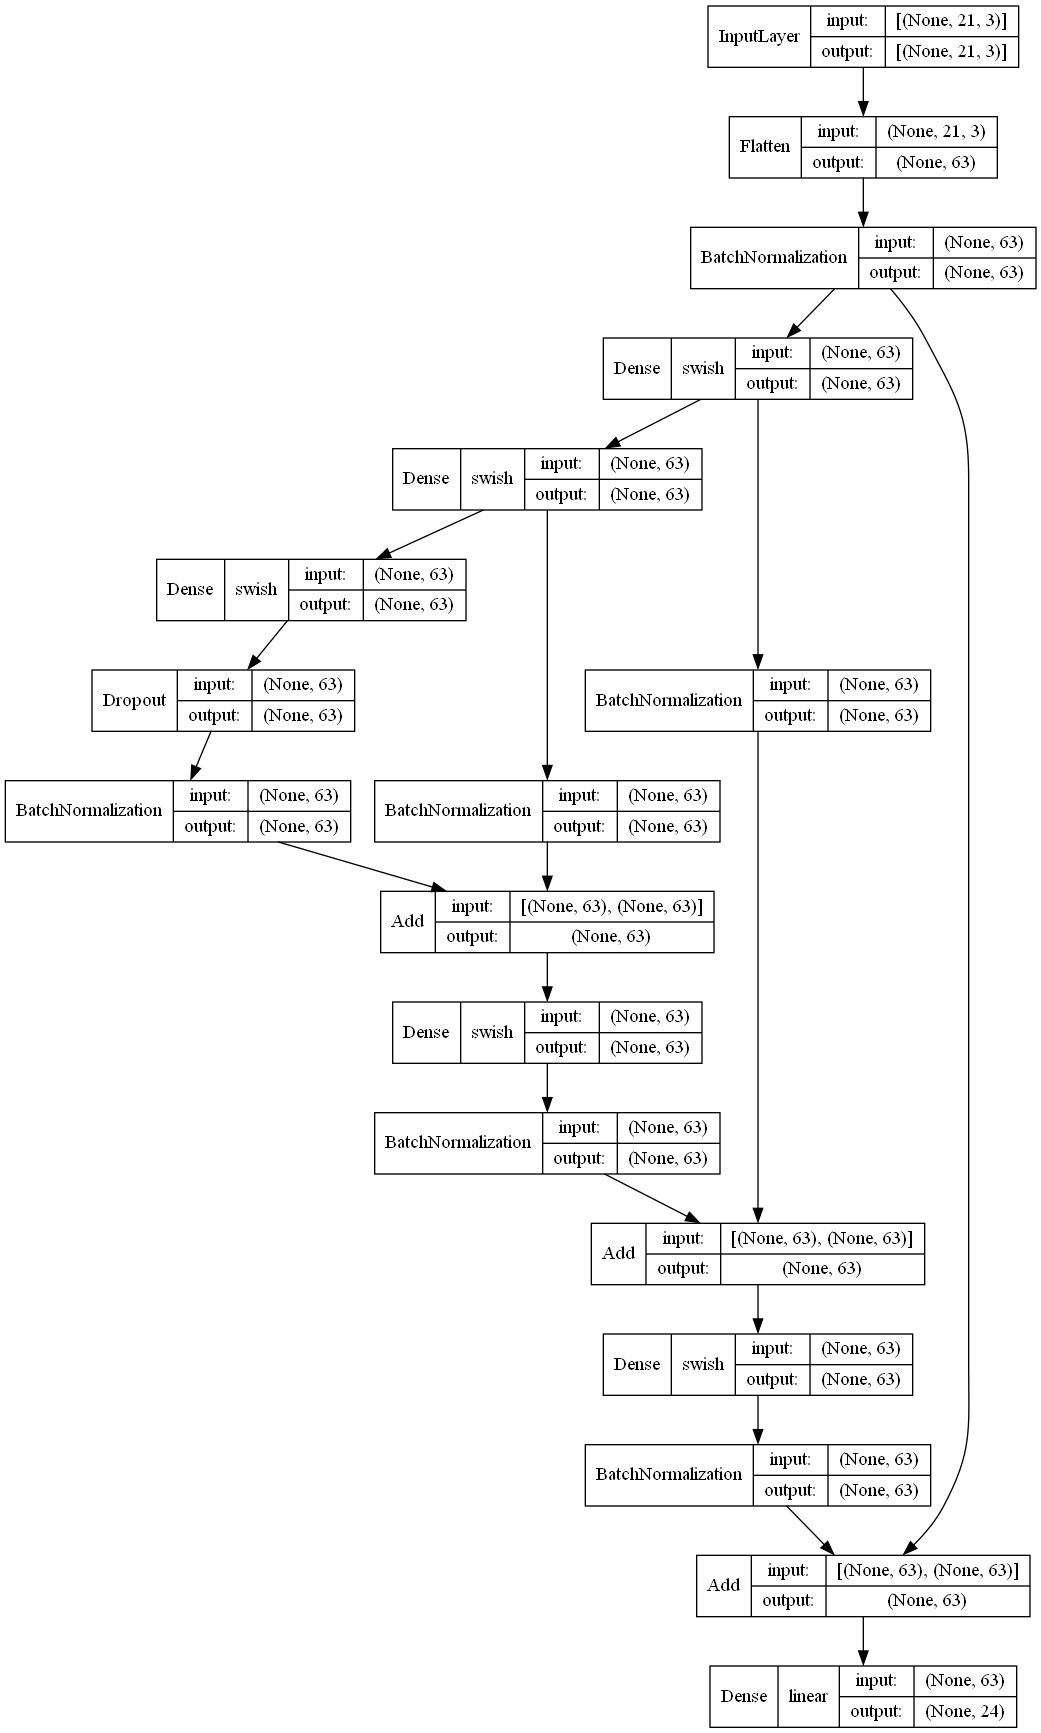

In [8]:
callback_csv = tf.keras.callbacks.CSVLogger(training_log_path,separator=';')


model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


if doFit is True:
    # save weights to file
    if modelCallbacks:
        # Save model with best results (Loss and Accuracy)
        best_loss_path = main_path + '/BestLoss/cp.ckpt'
        cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(filepath=best_loss_path,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                verbose=0)

        best_accuracy_path = main_path + '/BestAccuracy/cp.ckpt'
        cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(filepath=best_accuracy_path,
                                                                monitor='val_accuracy',
                                                                mode='max',
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                verbose=0)    
        callback_list = [cp_callback_loss,cp_callback_acc,callback_csv]
    else:
        callback_list = [callback_csv]
    # train model with imported training data
    history = model2.fit(train_data, train_label, 
                        epochs=numEpochs,
                        batch_size=batchSize, 
                        validation_data=(val_data, val_label),
                        callbacks=callback_list)
    
    model2.save(main_path + '/saved_model.h5')
    
else:
    model2 = tf.keras.models.load_model(main_path + '/saved_model.h5')
    
print("Model Validation Results:")   
results = model2.evaluate(val_data, val_label)

probability_model = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

tf.keras.utils.plot_model(model2, to_file='skip_connections_model.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

## Trainings-Resultate

In [9]:
if doPlots:
    results = np.array(np.genfromtxt(training_log_path, delimiter=';',skip_header=1)) ## Load training_log

    fig = plt.figure(figsize=(18,10))
    gs = fig.add_gridspec(2,2,width_ratios=[1.2,2])
    ax_acc = fig.add_subplot(gs[0, 0])
    plt.plot(results[:,0], results[:,1]*100,'-',linewidth=3, color='darkgreen') ## Training accuracy
    plt.plot(results[:,0], results[:,3]*100,'-', linewidth=2, color='green') ## Validation accuracy
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.xlim([0,np.max(results[:,0])])
    plt.ylim([0,100])
    plt.grid()

    ax_loss = fig.add_subplot(gs[1, 0])
    plt.plot(results[:,0], results[:,2],'-',linewidth=3, color='darkgreen') ## Training loss
    plt.plot(results[:,0], results[:,4],'-', linewidth=2, color='green') ## Validation loss
    plt.legend(['Training', 'Validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

    ax_cm = fig.add_subplot(gs[:, 1])
    classifier = estimator(probability_model, classes)
    ConfusionMatrixDisplay.from_estimator(estimator=classifier, X=val_data, y=val_label,display_labels=classes, 
                                          normalize='true',cmap='Blues',ax=ax_cm,colorbar=False)
    ax_cm.set_title('Confusion Matrix')


    if doFit:
        plt.savefig(main_path+'/results.svg', format='svg')

## Modelltest mit Real-time Kamerainput

In [25]:
import time

# For webcam input:
font                   = cv2.FONT_HERSHEY_SIMPLEX
position               = (0,300)
fontScale              = 2
fontColor              = (255,255,0)
fontThickness          = 3

minConfidence          = 0.7

# change input stream for external camera
cap = cv2.VideoCapture(1)
with mp_hands.Hands(
    model_complexity=1,               # Critical Parameter: Simplified Model (model_complexity < 1) delivers worse results
    min_detection_confidence=0.5,
    max_num_hands=1,
    min_tracking_confidence=0.8) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        t1 = time.time()
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        tm = time.time()

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        vec = np.zeros((21,3))
        t2 = time.time()
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

                for j in range(21):
                    lm = np.array([hand_landmarks.landmark[j].x,hand_landmarks.landmark[j].y,hand_landmarks.landmark[j].z], dtype=float)
                    vec[j,:] = lm
            input_vec = np.array([vec])
        
            # Flip the image horizontally for a selfie-view display.
            predictions = probability_model.predict(input_vec)
            t2 = time.time()
            image = cv2.flip(image, 1)
            
            if np.max(predictions)>minConfidence:
                label = classes[np.argmax(predictions)] + ', ' + str(np.round(np.max(predictions)*100))   
                print(label, np.max(predictions))
            else:
                label = '-'
            cv2.putText(image,label,position,font,fontScale,fontColor,thickness=fontThickness)                    
        else:
            image = cv2.flip(image, 1) 
        
        
        print("Inference: " + str((t2-t1)*1e3) + ' ms, MediaPipe: ' + str((tm-t1)*1e3) + ' ms')
        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
            
            
            
cap.release()
cv2.destroyAllWindows()

Inference: 49.45969581604004 ms, MediaPipe: 49.45969581604004 ms
Inference: 66.2841796875 ms, MediaPipe: 66.2841796875 ms
Inference: 62.94536590576172 ms, MediaPipe: 61.948537826538086 ms
Inference: 69.98300552368164 ms, MediaPipe: 68.96638870239258 ms
Inference: 61.640024185180664 ms, MediaPipe: 61.640024185180664 ms
Inference: 51.29742622375488 ms, MediaPipe: 51.29742622375488 ms
Inference: 47.19972610473633 ms, MediaPipe: 47.19972610473633 ms
Inference: 50.951242446899414 ms, MediaPipe: 49.55267906188965 ms
Inference: 51.61929130554199 ms, MediaPipe: 50.464630126953125 ms
Inference: 54.38828468322754 ms, MediaPipe: 54.38828468322754 ms
Inference: 52.51812934875488 ms, MediaPipe: 52.51812934875488 ms
Inference: 43.80154609680176 ms, MediaPipe: 43.80154609680176 ms
Inference: 51.26380920410156 ms, MediaPipe: 51.26380920410156 ms
Inference: 54.267168045043945 ms, MediaPipe: 54.267168045043945 ms
Inference: 43.24603080749512 ms, MediaPipe: 41.77570343017578 ms
Inference: 56.305408477783

1/1 [==============================] - 0s 29ms/step
B, 100.0 0.99836916
Inference: 116.51277542114258 ms, MediaPipe: 35.45808792114258 ms
1/1 [==============================] - 0s 40ms/step
B, 100.0 0.99851745
Inference: 124.43351745605469 ms, MediaPipe: 31.57663345336914 ms
1/1 [==============================] - 0s 34ms/step
B, 100.0 0.9976999
Inference: 125.41794776916504 ms, MediaPipe: 32.68265724182129 ms
1/1 [==============================] - 0s 30ms/step
B, 100.0 0.99786645
Inference: 120.29051780700684 ms, MediaPipe: 30.437946319580078 ms
1/1 [==============================] - 0s 36ms/step
B, 100.0 0.9979469
Inference: 119.04358863830566 ms, MediaPipe: 33.80179405212402 ms
1/1 [==============================] - 0s 27ms/step
B, 100.0 0.99644417
Inference: 113.9519214630127 ms, MediaPipe: 29.279470443725586 ms
1/1 [==============================] - 0s 37ms/step
B, 100.0 0.9969338
Inference: 117.25521087646484 ms, MediaPipe: 30.582904815673828 ms
1/1 [==============================

B, 100.0 0.99762446
Inference: 122.74885177612305 ms, MediaPipe: 41.718482971191406 ms
1/1 [==============================] - 0s 27ms/step
B, 100.0 0.99832934
Inference: 122.54095077514648 ms, MediaPipe: 26.547670364379883 ms
1/1 [==============================] - 0s 32ms/step
B, 100.0 0.9985796
Inference: 112.75410652160645 ms, MediaPipe: 27.71902084350586 ms
1/1 [==============================] - 0s 32ms/step
B, 100.0 0.99819666
Inference: 107.18989372253418 ms, MediaPipe: 26.927709579467773 ms
1/1 [==============================] - 0s 33ms/step
B, 100.0 0.9978173
Inference: 109.06195640563965 ms, MediaPipe: 29.902219772338867 ms
1/1 [==============================] - 0s 30ms/step
B, 100.0 0.9981007
Inference: 108.69979858398438 ms, MediaPipe: 27.524471282958984 ms
1/1 [==============================] - 0s 31ms/step
B, 100.0 0.99817467
Inference: 109.84349250793457 ms, MediaPipe: 29.731035232543945 ms
1/1 [==============================] - 0s 31ms/step
B, 100.0 0.9981012
Inference: 1

Inference: 52.82092094421387 ms, MediaPipe: 52.82092094421387 ms
Inference: 45.47452926635742 ms, MediaPipe: 45.47452926635742 ms
Inference: 35.52651405334473 ms, MediaPipe: 35.52651405334473 ms
Inference: 42.31524467468262 ms, MediaPipe: 42.31524467468262 ms
Inference: 50.98152160644531 ms, MediaPipe: 50.98152160644531 ms
Inference: 46.78153991699219 ms, MediaPipe: 46.78153991699219 ms
Inference: 56.46228790283203 ms, MediaPipe: 55.94992637634277 ms
Inference: 37.950754165649414 ms, MediaPipe: 37.950754165649414 ms
Inference: 40.55213928222656 ms, MediaPipe: 40.55213928222656 ms
Inference: 45.8986759185791 ms, MediaPipe: 45.8986759185791 ms
Inference: 35.555124282836914 ms, MediaPipe: 35.555124282836914 ms
Inference: 37.04428672790527 ms, MediaPipe: 36.539554595947266 ms
Inference: 41.53633117675781 ms, MediaPipe: 41.53633117675781 ms
Inference: 36.46063804626465 ms, MediaPipe: 35.2630615234375 ms
Inference: 38.720130920410156 ms, MediaPipe: 37.420034408569336 ms
Inference: 36.5378856

Inference: 45.73416709899902 ms, MediaPipe: 45.73416709899902 ms
Inference: 36.31472587585449 ms, MediaPipe: 36.31472587585449 ms
Inference: 36.09013557434082 ms, MediaPipe: 36.09013557434082 ms
Inference: 39.20602798461914 ms, MediaPipe: 39.20602798461914 ms
Inference: 38.60044479370117 ms, MediaPipe: 38.60044479370117 ms
Inference: 43.14732551574707 ms, MediaPipe: 43.14732551574707 ms
Inference: 40.137290954589844 ms, MediaPipe: 40.137290954589844 ms
Inference: 39.05653953552246 ms, MediaPipe: 37.940263748168945 ms
Inference: 43.08748245239258 ms, MediaPipe: 43.08748245239258 ms
Inference: 36.4527702331543 ms, MediaPipe: 36.4527702331543 ms
Inference: 47.774314880371094 ms, MediaPipe: 47.774314880371094 ms
Inference: 41.43857955932617 ms, MediaPipe: 40.11249542236328 ms
Inference: 42.82331466674805 ms, MediaPipe: 42.82331466674805 ms
Inference: 41.5647029876709 ms, MediaPipe: 41.5647029876709 ms
Inference: 35.48169136047363 ms, MediaPipe: 35.48169136047363 ms
Inference: 36.0867977142

Inference: 62.213897705078125 ms, MediaPipe: 62.213897705078125 ms
Inference: 38.8491153717041 ms, MediaPipe: 38.8491153717041 ms
Inference: 39.557695388793945 ms, MediaPipe: 39.557695388793945 ms
Inference: 39.34478759765625 ms, MediaPipe: 38.34819793701172 ms
Inference: 59.79490280151367 ms, MediaPipe: 58.78734588623047 ms
Inference: 47.629356384277344 ms, MediaPipe: 47.629356384277344 ms
Inference: 58.71438980102539 ms, MediaPipe: 57.646989822387695 ms
Inference: 49.108266830444336 ms, MediaPipe: 48.108816146850586 ms
Inference: 48.16889762878418 ms, MediaPipe: 47.16849327087402 ms
Inference: 51.657676696777344 ms, MediaPipe: 51.657676696777344 ms
Inference: 52.9475212097168 ms, MediaPipe: 51.918745040893555 ms
Inference: 49.95417594909668 ms, MediaPipe: 48.95377159118652 ms
Inference: 39.52312469482422 ms, MediaPipe: 39.52312469482422 ms
Inference: 41.3823127746582 ms, MediaPipe: 41.3823127746582 ms
Inference: 55.03416061401367 ms, MediaPipe: 54.036855697631836 ms
Inference: 52.867

1/1 [==============================] - 0s 33ms/step
C, 100.0 0.9994772
Inference: 120.8643913269043 ms, MediaPipe: 34.27290916442871 ms
1/1 [==============================] - 0s 34ms/step
C, 100.0 0.9994653
Inference: 128.7853717803955 ms, MediaPipe: 36.1483097076416 ms
1/1 [==============================] - 0s 35ms/step
C, 100.0 0.99957114
Inference: 124.27210807800293 ms, MediaPipe: 33.40744972229004 ms
1/1 [==============================] - 0s 44ms/step
C, 100.0 0.99949205
Inference: 150.10643005371094 ms, MediaPipe: 36.50069236755371 ms
1/1 [==============================] - 0s 36ms/step
C, 100.0 0.9995516
Inference: 136.3844871520996 ms, MediaPipe: 29.16574478149414 ms
1/1 [==============================] - 0s 29ms/step
C, 100.0 0.99839395
Inference: 109.10391807556152 ms, MediaPipe: 30.367612838745117 ms
1/1 [==============================] - 0s 36ms/step
C, 100.0 0.998487
Inference: 120.05281448364258 ms, MediaPipe: 30.75695037841797 ms
1/1 [==============================] - 0s 

Inference: 51.339149475097656 ms, MediaPipe: 51.339149475097656 ms
Inference: 43.999671936035156 ms, MediaPipe: 43.999671936035156 ms
Inference: 36.75127029418945 ms, MediaPipe: 36.75127029418945 ms
Inference: 46.11063003540039 ms, MediaPipe: 46.11063003540039 ms
Inference: 41.46862030029297 ms, MediaPipe: 40.47107696533203 ms
Inference: 35.745859146118164 ms, MediaPipe: 35.745859146118164 ms
Inference: 42.807579040527344 ms, MediaPipe: 41.8095588684082 ms
Inference: 36.91220283508301 ms, MediaPipe: 36.91220283508301 ms
Inference: 42.61660575866699 ms, MediaPipe: 42.61660575866699 ms
Inference: 38.160085678100586 ms, MediaPipe: 38.160085678100586 ms
Inference: 34.81578826904297 ms, MediaPipe: 34.81578826904297 ms
Inference: 36.110639572143555 ms, MediaPipe: 36.110639572143555 ms
Inference: 39.01982307434082 ms, MediaPipe: 39.01982307434082 ms
Inference: 38.530826568603516 ms, MediaPipe: 38.530826568603516 ms
Inference: 38.72179985046387 ms, MediaPipe: 37.72425651550293 ms
Inference: 37

Inference: 41.21065139770508 ms, MediaPipe: 40.18425941467285 ms
Inference: 56.12444877624512 ms, MediaPipe: 56.12444877624512 ms
Inference: 39.635658264160156 ms, MediaPipe: 38.59424591064453 ms
Inference: 43.24817657470703 ms, MediaPipe: 42.24991798400879 ms
Inference: 52.706241607666016 ms, MediaPipe: 51.53155326843262 ms
Inference: 54.357051849365234 ms, MediaPipe: 54.357051849365234 ms
Inference: 44.25191879272461 ms, MediaPipe: 44.25191879272461 ms
Inference: 39.01481628417969 ms, MediaPipe: 39.01481628417969 ms
Inference: 37.41121292114258 ms, MediaPipe: 37.41121292114258 ms
Inference: 37.04524040222168 ms, MediaPipe: 36.04769706726074 ms
Inference: 50.817251205444336 ms, MediaPipe: 50.817251205444336 ms
Inference: 40.14897346496582 ms, MediaPipe: 40.14897346496582 ms
Inference: 41.00823402404785 ms, MediaPipe: 40.03715515136719 ms
Inference: 36.84878349304199 ms, MediaPipe: 36.84878349304199 ms
Inference: 37.207841873168945 ms, MediaPipe: 37.207841873168945 ms
Inference: 48.005

Inference: 37.779808044433594 ms, MediaPipe: 37.779808044433594 ms
Inference: 46.31853103637695 ms, MediaPipe: 46.31853103637695 ms
Inference: 46.18549346923828 ms, MediaPipe: 46.18549346923828 ms
Inference: 53.606510162353516 ms, MediaPipe: 52.41990089416504 ms
Inference: 46.11349105834961 ms, MediaPipe: 45.11523246765137 ms
Inference: 43.78485679626465 ms, MediaPipe: 43.78485679626465 ms
Inference: 47.38759994506836 ms, MediaPipe: 46.88215255737305 ms
Inference: 40.369510650634766 ms, MediaPipe: 40.369510650634766 ms
Inference: 45.24636268615723 ms, MediaPipe: 45.24636268615723 ms
Inference: 46.891212463378906 ms, MediaPipe: 46.38671875 ms
Inference: 53.93099784851074 ms, MediaPipe: 53.93099784851074 ms
Inference: 40.05908966064453 ms, MediaPipe: 40.05908966064453 ms
Inference: 48.543691635131836 ms, MediaPipe: 48.543691635131836 ms
Inference: 38.70391845703125 ms, MediaPipe: 38.70391845703125 ms
Inference: 35.11166572570801 ms, MediaPipe: 35.11166572570801 ms
Inference: 36.823749542

Inference: 44.399261474609375 ms, MediaPipe: 43.29395294189453 ms
Inference: 43.85733604431152 ms, MediaPipe: 43.85733604431152 ms
Inference: 44.35324668884277 ms, MediaPipe: 44.35324668884277 ms
Inference: 43.50852966308594 ms, MediaPipe: 43.50852966308594 ms
Inference: 42.89102554321289 ms, MediaPipe: 42.89102554321289 ms
Inference: 48.921823501586914 ms, MediaPipe: 47.924041748046875 ms
Inference: 47.81603813171387 ms, MediaPipe: 47.81603813171387 ms
Inference: 44.4791316986084 ms, MediaPipe: 44.4791316986084 ms
Inference: 51.50628089904785 ms, MediaPipe: 51.50628089904785 ms
Inference: 41.489362716674805 ms, MediaPipe: 41.489362716674805 ms
Inference: 50.15730857849121 ms, MediaPipe: 50.15730857849121 ms
Inference: 52.657365798950195 ms, MediaPipe: 51.656484603881836 ms
Inference: 49.77250099182129 ms, MediaPipe: 49.77250099182129 ms
Inference: 47.734975814819336 ms, MediaPipe: 47.734975814819336 ms
Inference: 51.25236511230469 ms, MediaPipe: 50.058841705322266 ms
Inference: 41.301

Inference: 45.30787467956543 ms, MediaPipe: 45.30787467956543 ms
Inference: 37.895917892456055 ms, MediaPipe: 37.895917892456055 ms
Inference: 40.856361389160156 ms, MediaPipe: 40.856361389160156 ms
Inference: 45.313358306884766 ms, MediaPipe: 45.313358306884766 ms
Inference: 35.67981719970703 ms, MediaPipe: 35.67981719970703 ms
Inference: 45.41802406311035 ms, MediaPipe: 45.41802406311035 ms
Inference: 42.05727577209473 ms, MediaPipe: 41.043758392333984 ms
Inference: 39.633750915527344 ms, MediaPipe: 39.633750915527344 ms
Inference: 40.01665115356445 ms, MediaPipe: 40.01665115356445 ms
Inference: 46.32377624511719 ms, MediaPipe: 46.32377624511719 ms
Inference: 43.58673095703125 ms, MediaPipe: 43.58673095703125 ms
Inference: 44.13151741027832 ms, MediaPipe: 44.13151741027832 ms
Inference: 45.20368576049805 ms, MediaPipe: 45.20368576049805 ms
Inference: 43.13373565673828 ms, MediaPipe: 42.11831092834473 ms
Inference: 44.29006576538086 ms, MediaPipe: 44.29006576538086 ms
Inference: 53.09

1/1 [==============================] - 0s 27ms/step
F, 99.0 0.99423414
Inference: 109.65967178344727 ms, MediaPipe: 26.668071746826172 ms
1/1 [==============================] - 0s 38ms/step
F, 96.0 0.9617509
Inference: 116.98079109191895 ms, MediaPipe: 28.059959411621094 ms
Inference: 33.60557556152344 ms, MediaPipe: 32.43899345397949 ms
Inference: 37.93978691101074 ms, MediaPipe: 37.93978691101074 ms
Inference: 36.32354736328125 ms, MediaPipe: 36.32354736328125 ms
Inference: 38.23089599609375 ms, MediaPipe: 38.23089599609375 ms
Inference: 35.436153411865234 ms, MediaPipe: 35.436153411865234 ms
Inference: 41.4433479309082 ms, MediaPipe: 40.24004936218262 ms
Inference: 38.68412971496582 ms, MediaPipe: 38.68412971496582 ms
Inference: 38.83671760559082 ms, MediaPipe: 38.83671760559082 ms
Inference: 41.5952205657959 ms, MediaPipe: 40.12131690979004 ms
Inference: 43.81561279296875 ms, MediaPipe: 43.81561279296875 ms
Inference: 41.9468879699707 ms, MediaPipe: 41.9468879699707 ms
Inference: 4

Inference: 61.21325492858887 ms, MediaPipe: 60.21690368652344 ms
Inference: 56.18882179260254 ms, MediaPipe: 55.196285247802734 ms
Inference: 41.446685791015625 ms, MediaPipe: 41.446685791015625 ms
Inference: 37.928104400634766 ms, MediaPipe: 36.92793846130371 ms
Inference: 43.608665466308594 ms, MediaPipe: 43.608665466308594 ms
Inference: 45.45331001281738 ms, MediaPipe: 44.18182373046875 ms
Inference: 35.82334518432617 ms, MediaPipe: 35.82334518432617 ms
Inference: 41.016578674316406 ms, MediaPipe: 41.016578674316406 ms
Inference: 45.709848403930664 ms, MediaPipe: 44.34490203857422 ms
Inference: 40.012359619140625 ms, MediaPipe: 40.012359619140625 ms
Inference: 39.58630561828613 ms, MediaPipe: 39.58630561828613 ms
Inference: 48.62499237060547 ms, MediaPipe: 48.62499237060547 ms
Inference: 40.11654853820801 ms, MediaPipe: 40.11654853820801 ms
Inference: 37.41049766540527 ms, MediaPipe: 37.41049766540527 ms
1/1 [==============================] - 0s 31ms/step
C, 72.0 0.7159129
Inference

Inference: 45.32980918884277 ms, MediaPipe: 45.32980918884277 ms
Inference: 59.6010684967041 ms, MediaPipe: 59.6010684967041 ms
Inference: 49.653053283691406 ms, MediaPipe: 49.653053283691406 ms
Inference: 55.350303649902344 ms, MediaPipe: 55.350303649902344 ms
Inference: 43.99847984313965 ms, MediaPipe: 43.99847984313965 ms
Inference: 41.40353202819824 ms, MediaPipe: 41.40353202819824 ms
Inference: 44.6467399597168 ms, MediaPipe: 44.6467399597168 ms
Inference: 44.585227966308594 ms, MediaPipe: 44.585227966308594 ms
1/1 [==============================] - 0s 30ms/step
Inference: 155.08627891540527 ms, MediaPipe: 63.96126747131348 ms
Inference: 27.277708053588867 ms, MediaPipe: 26.267051696777344 ms
1/1 [==============================] - 0s 38ms/step
G, 100.0 0.9967103
Inference: 146.64673805236816 ms, MediaPipe: 59.53812599182129 ms
1/1 [==============================] - 0s 27ms/step
G, 100.0 0.998679
Inference: 101.98426246643066 ms, MediaPipe: 29.436349868774414 ms
1/1 [==============

Inference: 42.327165603637695 ms, MediaPipe: 41.12052917480469 ms
Inference: 42.33384132385254 ms, MediaPipe: 40.90452194213867 ms
Inference: 46.52070999145508 ms, MediaPipe: 46.52070999145508 ms
Inference: 39.438486099243164 ms, MediaPipe: 38.44118118286133 ms
Inference: 40.3594970703125 ms, MediaPipe: 40.3594970703125 ms
Inference: 39.752960205078125 ms, MediaPipe: 39.752960205078125 ms
1/1 [==============================] - 0s 36ms/step
G, 94.0 0.9415488
Inference: 178.7569522857666 ms, MediaPipe: 84.65170860290527 ms
1/1 [==============================] - 0s 31ms/step
Inference: 118.96467208862305 ms, MediaPipe: 28.384685516357422 ms
1/1 [==============================] - 0s 32ms/step
H, 86.0 0.863648
Inference: 109.65585708618164 ms, MediaPipe: 27.58502960205078 ms
1/1 [==============================] - 0s 28ms/step
H, 99.0 0.98775524
Inference: 118.07632446289062 ms, MediaPipe: 41.211843490600586 ms
1/1 [==============================] - 0s 38ms/step
H, 100.0 0.99727136
Inference

1/1 [==============================] - 0s 30ms/step
H, 100.0 0.9970427
Inference: 119.50111389160156 ms, MediaPipe: 34.9431037902832 ms
1/1 [==============================] - 0s 26ms/step
H, 99.0 0.9931356
Inference: 109.26556587219238 ms, MediaPipe: 28.062820434570312 ms
1/1 [==============================] - 0s 33ms/step
H, 100.0 0.9972459
Inference: 129.74119186401367 ms, MediaPipe: 37.58549690246582 ms
1/1 [==============================] - 0s 27ms/step
H, 100.0 0.9969921
Inference: 116.84775352478027 ms, MediaPipe: 36.65757179260254 ms
1/1 [==============================] - 0s 30ms/step
H, 100.0 0.99694926
Inference: 121.54603004455566 ms, MediaPipe: 35.60018539428711 ms
1/1 [==============================] - 0s 34ms/step
H, 100.0 0.9979924
Inference: 117.56277084350586 ms, MediaPipe: 26.04985237121582 ms
1/1 [==============================] - 0s 28ms/step
H, 100.0 0.99723995
Inference: 105.00335693359375 ms, MediaPipe: 26.839733123779297 ms
1/1 [==============================] - 

1/1 [==============================] - 0s 32ms/step
I, 99.0 0.9904985
Inference: 113.79218101501465 ms, MediaPipe: 31.97765350341797 ms
1/1 [==============================] - 0s 32ms/step
I, 99.0 0.9892608
Inference: 122.65825271606445 ms, MediaPipe: 28.822898864746094 ms
1/1 [==============================] - 0s 32ms/step
I, 99.0 0.9915481
Inference: 115.23914337158203 ms, MediaPipe: 31.13269805908203 ms
1/1 [==============================] - 0s 28ms/step
I, 99.0 0.990366
Inference: 118.78156661987305 ms, MediaPipe: 35.37297248840332 ms
1/1 [==============================] - 0s 29ms/step
I, 99.0 0.98935205
Inference: 110.3675365447998 ms, MediaPipe: 26.350021362304688 ms
1/1 [==============================] - 0s 30ms/step
I, 99.0 0.9894583
Inference: 109.82871055603027 ms, MediaPipe: 28.250932693481445 ms
1/1 [==============================] - 0s 30ms/step
I, 99.0 0.98898053
Inference: 117.55681037902832 ms, MediaPipe: 27.89020538330078 ms
1/1 [==============================] - 0s 37m

Inference: 41.106462478637695 ms, MediaPipe: 41.106462478637695 ms
Inference: 40.29989242553711 ms, MediaPipe: 40.29989242553711 ms
Inference: 42.8316593170166 ms, MediaPipe: 41.670799255371094 ms
Inference: 36.25082969665527 ms, MediaPipe: 36.25082969665527 ms
Inference: 41.52560234069824 ms, MediaPipe: 41.52560234069824 ms
1/1 [==============================] - 0s 34ms/step
I, 99.0 0.9916858
Inference: 147.2151279449463 ms, MediaPipe: 66.69831275939941 ms
1/1 [==============================] - 0s 32ms/step
I, 99.0 0.99154925
Inference: 116.04142189025879 ms, MediaPipe: 27.61697769165039 ms
1/1 [==============================] - 0s 34ms/step
I, 99.0 0.9942676
Inference: 122.53093719482422 ms, MediaPipe: 33.65921974182129 ms
1/1 [==============================] - 0s 29ms/step
I, 99.0 0.9930997
Inference: 115.13233184814453 ms, MediaPipe: 34.2099666595459 ms
1/1 [==============================] - 0s 31ms/step
I, 99.0 0.99422073
Inference: 111.6492748260498 ms, MediaPipe: 30.419349670410

Inference: 53.57170104980469 ms, MediaPipe: 53.57170104980469 ms
Inference: 42.92178153991699 ms, MediaPipe: 42.92178153991699 ms
Inference: 62.3166561126709 ms, MediaPipe: 62.3166561126709 ms
Inference: 58.49289894104004 ms, MediaPipe: 58.49289894104004 ms
Inference: 45.401811599731445 ms, MediaPipe: 45.401811599731445 ms
Inference: 46.14973068237305 ms, MediaPipe: 46.14973068237305 ms
Inference: 55.79495429992676 ms, MediaPipe: 54.50630187988281 ms
Inference: 44.8000431060791 ms, MediaPipe: 44.8000431060791 ms
Inference: 45.22585868835449 ms, MediaPipe: 44.236183166503906 ms
Inference: 48.76708984375 ms, MediaPipe: 47.608375549316406 ms
Inference: 57.06381797790527 ms, MediaPipe: 55.98044395446777 ms
Inference: 39.32690620422363 ms, MediaPipe: 39.32690620422363 ms
Inference: 50.93741416931152 ms, MediaPipe: 50.93741416931152 ms
Inference: 52.803993225097656 ms, MediaPipe: 52.803993225097656 ms
Inference: 45.316219329833984 ms, MediaPipe: 45.316219329833984 ms
Inference: 49.6406555175

Inference: 37.714481353759766 ms, MediaPipe: 36.4995002746582 ms
Inference: 43.88546943664551 ms, MediaPipe: 43.88546943664551 ms
Inference: 51.474809646606445 ms, MediaPipe: 51.474809646606445 ms
Inference: 53.29561233520508 ms, MediaPipe: 53.29561233520508 ms
Inference: 46.048879623413086 ms, MediaPipe: 46.048879623413086 ms
Inference: 39.00599479675293 ms, MediaPipe: 39.00599479675293 ms
Inference: 39.545297622680664 ms, MediaPipe: 39.545297622680664 ms
Inference: 46.697378158569336 ms, MediaPipe: 46.697378158569336 ms
Inference: 50.031185150146484 ms, MediaPipe: 50.031185150146484 ms
Inference: 48.97928237915039 ms, MediaPipe: 48.97928237915039 ms
Inference: 39.47281837463379 ms, MediaPipe: 39.47281837463379 ms
Inference: 38.865089416503906 ms, MediaPipe: 38.865089416503906 ms
Inference: 42.36412048339844 ms, MediaPipe: 42.36412048339844 ms
Inference: 44.852495193481445 ms, MediaPipe: 44.852495193481445 ms
Inference: 41.07522964477539 ms, MediaPipe: 41.07522964477539 ms
Inference: 

1/1 [==============================] - 0s 29ms/step
M, 97.0 0.9719857
Inference: 117.57278442382812 ms, MediaPipe: 27.83370018005371 ms
1/1 [==============================] - 0s 40ms/step
M, 99.0 0.9880521
Inference: 123.30055236816406 ms, MediaPipe: 28.934478759765625 ms
1/1 [==============================] - 0s 32ms/step
M, 98.0 0.97636366
Inference: 119.29106712341309 ms, MediaPipe: 35.38799285888672 ms
1/1 [==============================] - 0s 29ms/step
M, 99.0 0.9851066
Inference: 113.73662948608398 ms, MediaPipe: 26.98230743408203 ms
1/1 [==============================] - 0s 36ms/step
M, 99.0 0.98659456
Inference: 117.02275276184082 ms, MediaPipe: 30.170202255249023 ms
1/1 [==============================] - 0s 29ms/step
M, 98.0 0.98366404
Inference: 122.68185615539551 ms, MediaPipe: 28.528690338134766 ms
1/1 [==============================] - 0s 38ms/step
M, 99.0 0.99176323
Inference: 116.87493324279785 ms, MediaPipe: 31.2802791595459 ms
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 30ms/step
N, 95.0 0.9522597
Inference: 115.22293090820312 ms, MediaPipe: 28.944730758666992 ms
1/1 [==============================] - 0s 35ms/step
N, 88.0 0.8810928
Inference: 118.78824234008789 ms, MediaPipe: 28.293132781982422 ms
1/1 [==============================] - 0s 28ms/step
N, 94.0 0.943638
Inference: 115.36931991577148 ms, MediaPipe: 28.92780303955078 ms
1/1 [==============================] - 0s 37ms/step
N, 92.0 0.91677886
Inference: 120.20516395568848 ms, MediaPipe: 31.44073486328125 ms
1/1 [==============================] - 0s 31ms/step
N, 88.0 0.88292426
Inference: 114.93682861328125 ms, MediaPipe: 32.37438201904297 ms
1/1 [==============================] - 0s 32ms/step
N, 76.0 0.7630749
Inference: 121.97256088256836 ms, MediaPipe: 29.892444610595703 ms
1/1 [==============================] - 0s 32ms/step
N, 87.0 0.8659343
Inference: 111.70268058776855 ms, MediaPipe: 28.51080894470215 ms
1/1 [==============================] - 0s 28

Inference: 46.91338539123535 ms, MediaPipe: 45.915842056274414 ms
Inference: 44.883012771606445 ms, MediaPipe: 44.883012771606445 ms
Inference: 43.06507110595703 ms, MediaPipe: 43.06507110595703 ms
Inference: 42.61922836303711 ms, MediaPipe: 42.61922836303711 ms
Inference: 51.87368392944336 ms, MediaPipe: 50.847530364990234 ms
Inference: 47.615766525268555 ms, MediaPipe: 47.615766525268555 ms
Inference: 78.97710800170898 ms, MediaPipe: 78.97710800170898 ms
Inference: 81.6030502319336 ms, MediaPipe: 81.6030502319336 ms
Inference: 86.26842498779297 ms, MediaPipe: 86.26842498779297 ms
Inference: 69.16022300720215 ms, MediaPipe: 69.16022300720215 ms
Inference: 46.9212532043457 ms, MediaPipe: 45.92418670654297 ms
Inference: 48.22278022766113 ms, MediaPipe: 48.22278022766113 ms
Inference: 57.23977088928223 ms, MediaPipe: 57.23977088928223 ms
Inference: 89.82539176940918 ms, MediaPipe: 88.55390548706055 ms
Inference: 95.85881233215332 ms, MediaPipe: 95.85881233215332 ms
1/1 [=================

Inference: 35.721778869628906 ms, MediaPipe: 34.584999084472656 ms
Inference: 35.736799240112305 ms, MediaPipe: 34.62934494018555 ms
Inference: 40.543556213378906 ms, MediaPipe: 39.54768180847168 ms
Inference: 45.28164863586426 ms, MediaPipe: 45.28164863586426 ms
1/1 [==============================] - 0s 31ms/step
N, 99.0 0.9894314
Inference: 152.78196334838867 ms, MediaPipe: 70.24788856506348 ms
1/1 [==============================] - 0s 32ms/step
N, 99.0 0.98784816
Inference: 120.24855613708496 ms, MediaPipe: 31.189680099487305 ms
1/1 [==============================] - 0s 38ms/step
N, 99.0 0.9856609
Inference: 127.17127799987793 ms, MediaPipe: 30.6241512298584 ms
1/1 [==============================] - 0s 43ms/step
N, 98.0 0.9829336
Inference: 140.97261428833008 ms, MediaPipe: 35.4611873626709 ms
1/1 [==============================] - 0s 36ms/step
N, 98.0 0.98430735
Inference: 156.59403800964355 ms, MediaPipe: 41.72110557556152 ms
1/1 [==============================] - 0s 30ms/step
N, 

Inference: 64.3770694732666 ms, MediaPipe: 64.3770694732666 ms
Inference: 61.284780502319336 ms, MediaPipe: 60.282230377197266 ms
Inference: 62.618255615234375 ms, MediaPipe: 62.618255615234375 ms
Inference: 63.07792663574219 ms, MediaPipe: 61.83338165283203 ms
Inference: 65.98687171936035 ms, MediaPipe: 65.98687171936035 ms
Inference: 53.79033088684082 ms, MediaPipe: 53.79033088684082 ms
Inference: 54.73589897155762 ms, MediaPipe: 53.64656448364258 ms
Inference: 110.73637008666992 ms, MediaPipe: 110.73637008666992 ms
Inference: 93.68562698364258 ms, MediaPipe: 93.68562698364258 ms
Inference: 98.18053245544434 ms, MediaPipe: 98.18053245544434 ms
Inference: 111.01198196411133 ms, MediaPipe: 111.01198196411133 ms
Inference: 59.23819541931152 ms, MediaPipe: 59.23819541931152 ms
Inference: 53.46870422363281 ms, MediaPipe: 53.46870422363281 ms
Inference: 47.17564582824707 ms, MediaPipe: 47.17564582824707 ms
Inference: 55.80759048461914 ms, MediaPipe: 54.526329040527344 ms
Inference: 55.5522

Inference: 69.0305233001709 ms, MediaPipe: 69.0305233001709 ms
Inference: 73.90832901000977 ms, MediaPipe: 72.91054725646973 ms
1/1 [==============================] - 0s 34ms/step
Inference: 160.87818145751953 ms, MediaPipe: 74.8298168182373 ms
1/1 [==============================] - 0s 31ms/step
O, 83.0 0.8317129
Inference: 119.30060386657715 ms, MediaPipe: 28.543710708618164 ms
1/1 [==============================] - 0s 29ms/step
O, 88.0 0.87886804
Inference: 126.0366439819336 ms, MediaPipe: 33.976078033447266 ms
1/1 [==============================] - 0s 34ms/step
O, 92.0 0.9184883
Inference: 118.79515647888184 ms, MediaPipe: 34.68656539916992 ms
1/1 [==============================] - 0s 30ms/step
O, 85.0 0.8506931
Inference: 112.40243911743164 ms, MediaPipe: 27.09674835205078 ms
1/1 [==============================] - 0s 36ms/step
O, 93.0 0.93187714
Inference: 122.9245662689209 ms, MediaPipe: 37.81247138977051 ms
1/1 [==============================] - 0s 27ms/step
O, 84.0 0.844829
Infe

1/1 [==============================] - 0s 37ms/step
O, 87.0 0.874537
Inference: 135.66350936889648 ms, MediaPipe: 38.90728950500488 ms
1/1 [==============================] - 0s 41ms/step
O, 87.0 0.8689131
Inference: 156.477689743042 ms, MediaPipe: 43.40529441833496 ms
1/1 [==============================] - 0s 38ms/step
O, 86.0 0.860796
Inference: 141.86620712280273 ms, MediaPipe: 41.31674766540527 ms
1/1 [==============================] - 0s 38ms/step
O, 91.0 0.9141765
Inference: 142.50802993774414 ms, MediaPipe: 39.91818428039551 ms
Inference: 34.749746322631836 ms, MediaPipe: 33.376455307006836 ms
Inference: 65.9799575805664 ms, MediaPipe: 64.73994255065918 ms
Inference: 69.70024108886719 ms, MediaPipe: 69.70024108886719 ms
Inference: 70.87254524230957 ms, MediaPipe: 70.87254524230957 ms
Inference: 68.31645965576172 ms, MediaPipe: 68.31645965576172 ms
Inference: 68.87197494506836 ms, MediaPipe: 67.72780418395996 ms
Inference: 67.37184524536133 ms, MediaPipe: 66.83540344238281 ms
Infe

1/1 [==============================] - 0s 27ms/step
O, 98.0 0.977285
Inference: 101.75395011901855 ms, MediaPipe: 25.857925415039062 ms
1/1 [==============================] - 0s 27ms/step
O, 99.0 0.9905652
Inference: 106.12106323242188 ms, MediaPipe: 27.690887451171875 ms
1/1 [==============================] - 0s 29ms/step
O, 99.0 0.9894769
Inference: 105.25774955749512 ms, MediaPipe: 23.975849151611328 ms
1/1 [==============================] - 0s 38ms/step
O, 99.0 0.9890463
Inference: 119.66228485107422 ms, MediaPipe: 30.490398406982422 ms
1/1 [==============================] - 0s 38ms/step
O, 99.0 0.985802
Inference: 133.77046585083008 ms, MediaPipe: 34.949541091918945 ms
1/1 [==============================] - 0s 29ms/step
O, 99.0 0.98589534
Inference: 112.83040046691895 ms, MediaPipe: 32.01937675476074 ms
1/1 [==============================] - 0s 33ms/step
O, 98.0 0.9825606
Inference: 119.85087394714355 ms, MediaPipe: 35.54415702819824 ms
1/1 [==============================] - 0s 31

Inference: 44.90184783935547 ms, MediaPipe: 44.90184783935547 ms
Inference: 54.192304611206055 ms, MediaPipe: 54.192304611206055 ms
Inference: 50.52900314331055 ms, MediaPipe: 50.52900314331055 ms
Inference: 51.70631408691406 ms, MediaPipe: 50.57024955749512 ms
Inference: 46.06342315673828 ms, MediaPipe: 46.06342315673828 ms
Inference: 53.8787841796875 ms, MediaPipe: 52.87456512451172 ms
Inference: 41.84913635253906 ms, MediaPipe: 41.84913635253906 ms
Inference: 69.5657730102539 ms, MediaPipe: 69.5657730102539 ms
Inference: 50.24409294128418 ms, MediaPipe: 49.20363426208496 ms
Inference: 39.54577445983887 ms, MediaPipe: 38.54846954345703 ms
Inference: 44.472455978393555 ms, MediaPipe: 44.472455978393555 ms
Inference: 54.89993095397949 ms, MediaPipe: 54.89993095397949 ms
Inference: 49.3009090423584 ms, MediaPipe: 48.29978942871094 ms
Inference: 47.46651649475098 ms, MediaPipe: 46.04029655456543 ms
Inference: 47.62864112854004 ms, MediaPipe: 47.62864112854004 ms
Inference: 38.51366043090

Inference: 43.48468780517578 ms, MediaPipe: 42.38319396972656 ms
Inference: 37.711143493652344 ms, MediaPipe: 37.711143493652344 ms
Inference: 52.863359451293945 ms, MediaPipe: 52.863359451293945 ms
Inference: 40.29393196105957 ms, MediaPipe: 40.29393196105957 ms
Inference: 52.99520492553711 ms, MediaPipe: 52.99520492553711 ms
Inference: 55.97090721130371 ms, MediaPipe: 55.97090721130371 ms
Inference: 42.68145561218262 ms, MediaPipe: 42.68145561218262 ms
Inference: 42.78969764709473 ms, MediaPipe: 42.78969764709473 ms
Inference: 52.857160568237305 ms, MediaPipe: 51.58066749572754 ms
Inference: 37.11223602294922 ms, MediaPipe: 36.12804412841797 ms
Inference: 52.26778984069824 ms, MediaPipe: 52.26778984069824 ms
Inference: 56.01954460144043 ms, MediaPipe: 56.01954460144043 ms
Inference: 54.21948432922363 ms, MediaPipe: 54.21948432922363 ms
Inference: 41.53871536254883 ms, MediaPipe: 41.53871536254883 ms
Inference: 39.8256778717041 ms, MediaPipe: 39.8256778717041 ms
Inference: 52.37197875

Inference: 60.29081344604492 ms, MediaPipe: 60.29081344604492 ms
Inference: 47.11794853210449 ms, MediaPipe: 47.11794853210449 ms
Inference: 40.4515266418457 ms, MediaPipe: 40.4515266418457 ms
Inference: 42.067527770996094 ms, MediaPipe: 42.067527770996094 ms
Inference: 45.49098014831543 ms, MediaPipe: 45.49098014831543 ms
Inference: 43.99418830871582 ms, MediaPipe: 42.76108741760254 ms
Inference: 42.13523864746094 ms, MediaPipe: 41.13650321960449 ms
Inference: 46.97728157043457 ms, MediaPipe: 46.473026275634766 ms
Inference: 38.96760940551758 ms, MediaPipe: 38.96760940551758 ms
Inference: 39.23463821411133 ms, MediaPipe: 39.23463821411133 ms
Inference: 49.33500289916992 ms, MediaPipe: 48.33221435546875 ms
Inference: 47.34158515930176 ms, MediaPipe: 47.34158515930176 ms
Inference: 46.881914138793945 ms, MediaPipe: 46.881914138793945 ms
Inference: 51.47838592529297 ms, MediaPipe: 51.47838592529297 ms
Inference: 59.47065353393555 ms, MediaPipe: 59.47065353393555 ms
Inference: 58.95137786

1/1 [==============================] - 0s 30ms/step
Q, 97.0 0.9669712
Inference: 108.3366870880127 ms, MediaPipe: 28.257131576538086 ms
1/1 [==============================] - 0s 31ms/step
Q, 94.0 0.9419647
Inference: 109.62963104248047 ms, MediaPipe: 27.731657028198242 ms
1/1 [==============================] - 0s 31ms/step
Q, 96.0 0.9605247
Inference: 113.89017105102539 ms, MediaPipe: 27.04596519470215 ms
1/1 [==============================] - 0s 30ms/step
Q, 96.0 0.95651317
Inference: 113.80648612976074 ms, MediaPipe: 33.83350372314453 ms
1/1 [==============================] - 0s 31ms/step
Q, 97.0 0.96961504
Inference: 114.51864242553711 ms, MediaPipe: 29.09064292907715 ms
1/1 [==============================] - 0s 34ms/step
Q, 98.0 0.975628
Inference: 114.33196067810059 ms, MediaPipe: 28.435707092285156 ms
1/1 [==============================] - 0s 29ms/step
Q, 98.0 0.97850865
Inference: 113.8007640838623 ms, MediaPipe: 28.278112411499023 ms
1/1 [==============================] - 0s 31

1/1 [==============================] - 0s 29ms/step
Inference: 103.57117652893066 ms, MediaPipe: 29.674053192138672 ms
1/1 [==============================] - 0s 33ms/step
Q, 95.0 0.95262617
Inference: 119.71759796142578 ms, MediaPipe: 27.4965763092041 ms
1/1 [==============================] - 0s 31ms/step
Q, 93.0 0.9305264
Inference: 114.25018310546875 ms, MediaPipe: 28.348684310913086 ms
1/1 [==============================] - 0s 31ms/step
Q, 96.0 0.95656127
Inference: 114.69101905822754 ms, MediaPipe: 34.52730178833008 ms
1/1 [==============================] - 0s 28ms/step
Q, 98.0 0.9787371
Inference: 105.70812225341797 ms, MediaPipe: 26.555776596069336 ms
1/1 [==============================] - 0s 39ms/step
Q, 98.0 0.97888625
Inference: 120.82409858703613 ms, MediaPipe: 32.53626823425293 ms
1/1 [==============================] - 0s 28ms/step
Q, 97.0 0.9662026
Inference: 105.17024993896484 ms, MediaPipe: 28.131961822509766 ms
1/1 [==============================] - 0s 29ms/step
Q, 96.0 

Inference: 45.6385612487793 ms, MediaPipe: 44.178009033203125 ms
Inference: 37.99581527709961 ms, MediaPipe: 36.99827194213867 ms
Inference: 37.610769271850586 ms, MediaPipe: 37.610769271850586 ms
Inference: 39.49451446533203 ms, MediaPipe: 39.49451446533203 ms
Inference: 43.76673698425293 ms, MediaPipe: 43.76673698425293 ms
Inference: 51.941633224487305 ms, MediaPipe: 51.941633224487305 ms
Inference: 49.939870834350586 ms, MediaPipe: 48.42519760131836 ms
Inference: 46.69046401977539 ms, MediaPipe: 46.69046401977539 ms
Inference: 48.786163330078125 ms, MediaPipe: 48.786163330078125 ms
Inference: 42.72818565368652 ms, MediaPipe: 42.72818565368652 ms
Inference: 51.650047302246094 ms, MediaPipe: 51.650047302246094 ms
Inference: 47.57428169250488 ms, MediaPipe: 47.57428169250488 ms
Inference: 54.132938385009766 ms, MediaPipe: 54.132938385009766 ms
Inference: 53.01809310913086 ms, MediaPipe: 53.01809310913086 ms
Inference: 38.06662559509277 ms, MediaPipe: 38.06662559509277 ms
Inference: 37.

Inference: 114.02559280395508 ms, MediaPipe: 30.65800666809082 ms
Inference: 37.49561309814453 ms, MediaPipe: 37.49561309814453 ms
Inference: 39.522409439086914 ms, MediaPipe: 39.522409439086914 ms
Inference: 38.665771484375 ms, MediaPipe: 38.665771484375 ms
Inference: 43.51496696472168 ms, MediaPipe: 43.51496696472168 ms
Inference: 36.751508712768555 ms, MediaPipe: 36.751508712768555 ms
Inference: 45.659780502319336 ms, MediaPipe: 44.65627670288086 ms
Inference: 52.42156982421875 ms, MediaPipe: 52.42156982421875 ms
Inference: 46.881675720214844 ms, MediaPipe: 45.76516151428223 ms
Inference: 43.4565544128418 ms, MediaPipe: 43.4565544128418 ms
Inference: 42.29569435119629 ms, MediaPipe: 42.29569435119629 ms
Inference: 46.4785099029541 ms, MediaPipe: 46.4785099029541 ms
Inference: 45.22967338562012 ms, MediaPipe: 44.23069953918457 ms
Inference: 51.50318145751953 ms, MediaPipe: 51.50318145751953 ms
Inference: 51.506996154785156 ms, MediaPipe: 51.506996154785156 ms
Inference: 46.5087890625

1/1 [==============================] - 0s 41ms/step
N, 88.0 0.8760293
Inference: 129.44626808166504 ms, MediaPipe: 31.40544891357422 ms
1/1 [==============================] - 0s 29ms/step
S, 76.0 0.7638354
Inference: 128.06391716003418 ms, MediaPipe: 35.425424575805664 ms
1/1 [==============================] - 0s 29ms/step
S, 92.0 0.91821575
Inference: 116.2116527557373 ms, MediaPipe: 33.75053405761719 ms
1/1 [==============================] - 0s 32ms/step
S, 93.0 0.9276857
Inference: 163.95807266235352 ms, MediaPipe: 44.58189010620117 ms
1/1 [==============================] - 0s 30ms/step
S, 73.0 0.7271716
Inference: 113.70992660522461 ms, MediaPipe: 31.99934959411621 ms
1/1 [==============================] - 0s 41ms/step
S, 84.0 0.84059334
Inference: 143.60547065734863 ms, MediaPipe: 37.660837173461914 ms
1/1 [==============================] - 0s 35ms/step
S, 95.0 0.9503716
Inference: 132.54404067993164 ms, MediaPipe: 29.68287467956543 ms
1/1 [==============================] - 0s 34m

Inference: 38.971900939941406 ms, MediaPipe: 38.971900939941406 ms
Inference: 46.21005058288574 ms, MediaPipe: 45.17054557800293 ms
Inference: 35.93254089355469 ms, MediaPipe: 35.93254089355469 ms
Inference: 37.48130798339844 ms, MediaPipe: 37.48130798339844 ms
Inference: 35.90202331542969 ms, MediaPipe: 35.90202331542969 ms
Inference: 41.70083999633789 ms, MediaPipe: 41.70083999633789 ms
Inference: 36.682844161987305 ms, MediaPipe: 35.41684150695801 ms
Inference: 47.74045944213867 ms, MediaPipe: 46.60677909851074 ms
Inference: 45.60065269470215 ms, MediaPipe: 44.182777404785156 ms
Inference: 35.054683685302734 ms, MediaPipe: 35.054683685302734 ms
Inference: 45.807838439941406 ms, MediaPipe: 45.807838439941406 ms
Inference: 42.51575469970703 ms, MediaPipe: 42.51575469970703 ms
Inference: 43.43008995056152 ms, MediaPipe: 43.43008995056152 ms
Inference: 40.88282585144043 ms, MediaPipe: 40.88282585144043 ms
Inference: 45.38989067077637 ms, MediaPipe: 45.38989067077637 ms
Inference: 38.906

Inference: 48.151493072509766 ms, MediaPipe: 46.78630828857422 ms
Inference: 38.9249324798584 ms, MediaPipe: 38.9249324798584 ms
Inference: 38.67793083190918 ms, MediaPipe: 38.67793083190918 ms
Inference: 34.7597599029541 ms, MediaPipe: 34.7597599029541 ms
Inference: 36.32616996765137 ms, MediaPipe: 36.32616996765137 ms
Inference: 38.466691970825195 ms, MediaPipe: 38.466691970825195 ms
Inference: 48.78664016723633 ms, MediaPipe: 48.78664016723633 ms
Inference: 40.94195365905762 ms, MediaPipe: 40.94195365905762 ms
Inference: 42.72031784057617 ms, MediaPipe: 42.72031784057617 ms
Inference: 46.15926742553711 ms, MediaPipe: 46.15926742553711 ms
Inference: 42.4189567565918 ms, MediaPipe: 42.4189567565918 ms
Inference: 44.45028305053711 ms, MediaPipe: 44.45028305053711 ms
Inference: 52.70051956176758 ms, MediaPipe: 51.25284194946289 ms
Inference: 37.22858428955078 ms, MediaPipe: 37.22858428955078 ms
Inference: 39.28852081298828 ms, MediaPipe: 39.28852081298828 ms
Inference: 38.41853141784668

Inference: 35.83264350891113 ms, MediaPipe: 34.83891487121582 ms
Inference: 36.41939163208008 ms, MediaPipe: 36.41939163208008 ms
Inference: 50.17256736755371 ms, MediaPipe: 49.17430877685547 ms
Inference: 35.895347595214844 ms, MediaPipe: 34.89375114440918 ms
Inference: 45.86935043334961 ms, MediaPipe: 45.86935043334961 ms
Inference: 57.30152130126953 ms, MediaPipe: 57.30152130126953 ms
Inference: 39.53099250793457 ms, MediaPipe: 39.53099250793457 ms
Inference: 37.35089302062988 ms, MediaPipe: 36.35454177856445 ms
1/1 [==============================] - 0s 31ms/step
Inference: 145.4939842224121 ms, MediaPipe: 65.9036636352539 ms
Inference: 28.772830963134766 ms, MediaPipe: 28.772830963134766 ms
Inference: 44.10099983215332 ms, MediaPipe: 44.10099983215332 ms
1/1 [==============================] - 0s 33ms/step
Inference: 140.9153938293457 ms, MediaPipe: 60.26911735534668 ms
1/1 [==============================] - 0s 27ms/step
T, 78.0 0.7782877
Inference: 100.8303165435791 ms, MediaPipe: 

Inference: 48.790931701660156 ms, MediaPipe: 48.790931701660156 ms
Inference: 47.116756439208984 ms, MediaPipe: 47.116756439208984 ms
Inference: 37.02211380004883 ms, MediaPipe: 37.02211380004883 ms
Inference: 47.29270935058594 ms, MediaPipe: 47.29270935058594 ms
Inference: 36.49401664733887 ms, MediaPipe: 35.52746772766113 ms
Inference: 37.6591682434082 ms, MediaPipe: 36.66043281555176 ms
Inference: 36.489009857177734 ms, MediaPipe: 35.5219841003418 ms
Inference: 36.72671318054199 ms, MediaPipe: 36.72671318054199 ms
Inference: 38.59305381774902 ms, MediaPipe: 38.59305381774902 ms
Inference: 53.74026298522949 ms, MediaPipe: 52.733659744262695 ms
Inference: 41.15748405456543 ms, MediaPipe: 41.15748405456543 ms
Inference: 36.88979148864746 ms, MediaPipe: 36.88979148864746 ms
Inference: 36.722660064697266 ms, MediaPipe: 35.68911552429199 ms
Inference: 40.1151180267334 ms, MediaPipe: 38.954734802246094 ms
Inference: 40.66181182861328 ms, MediaPipe: 40.66181182861328 ms
Inference: 34.719705

1/1 [==============================] - 0s 35ms/step
T, 79.0 0.79010063
Inference: 121.79207801818848 ms, MediaPipe: 31.628847122192383 ms
1/1 [==============================] - 0s 31ms/step
T, 83.0 0.8315321
Inference: 117.40493774414062 ms, MediaPipe: 31.065940856933594 ms
1/1 [==============================] - 0s 32ms/step
T, 82.0 0.82181364
Inference: 117.78807640075684 ms, MediaPipe: 30.916929244995117 ms
1/1 [==============================] - 0s 33ms/step
T, 89.0 0.89207876
Inference: 125.23865699768066 ms, MediaPipe: 38.06042671203613 ms
1/1 [==============================] - 0s 34ms/step
T, 89.0 0.8933507
Inference: 136.2590789794922 ms, MediaPipe: 39.57724571228027 ms
1/1 [==============================] - 0s 27ms/step
T, 90.0 0.9018612
Inference: 109.45343971252441 ms, MediaPipe: 31.975746154785156 ms
1/1 [==============================] - 0s 28ms/step
T, 91.0 0.9073844
Inference: 105.3769588470459 ms, MediaPipe: 33.84232521057129 ms
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
T, 97.0 0.9738972
Inference: 126.40213966369629 ms, MediaPipe: 34.514427185058594 ms
1/1 [==============================] - 0s 33ms/step
T, 97.0 0.96635455
Inference: 127.18868255615234 ms, MediaPipe: 32.21249580383301 ms
1/1 [==============================] - 0s 33ms/step
T, 97.0 0.97281533
Inference: 119.61197853088379 ms, MediaPipe: 35.35127639770508 ms
1/1 [==============================] - 0s 36ms/step
T, 97.0 0.97027236
Inference: 128.13234329223633 ms, MediaPipe: 31.888961791992188 ms
1/1 [==============================] - 0s 32ms/step
T, 97.0 0.9686904
Inference: 122.97606468200684 ms, MediaPipe: 36.96584701538086 ms
1/1 [==============================] - 0s 33ms/step
T, 97.0 0.97225505
Inference: 117.3856258392334 ms, MediaPipe: 32.20367431640625 ms
1/1 [==============================] - 0s 33ms/step
T, 98.0 0.97619087
Inference: 126.71136856079102 ms, MediaPipe: 33.75601768493652 ms
1/1 [==============================] - 0s 

Inference: 42.39511489868164 ms, MediaPipe: 42.39511489868164 ms
Inference: 37.26935386657715 ms, MediaPipe: 37.26935386657715 ms
Inference: 44.30270195007324 ms, MediaPipe: 44.30270195007324 ms
Inference: 49.12376403808594 ms, MediaPipe: 47.90377616882324 ms
1/1 [==============================] - 0s 36ms/step
Inference: 168.5948371887207 ms, MediaPipe: 76.22480392456055 ms
1/1 [==============================] - 0s 32ms/step
Inference: 117.92755126953125 ms, MediaPipe: 31.058073043823242 ms
Inference: 35.77709197998047 ms, MediaPipe: 35.77709197998047 ms
1/1 [==============================] - 0s 41ms/step
Inference: 162.75644302368164 ms, MediaPipe: 66.03527069091797 ms
1/1 [==============================] - 0s 45ms/step
U, 79.0 0.7927415
Inference: 151.95655822753906 ms, MediaPipe: 38.08879852294922 ms
1/1 [==============================] - 0s 44ms/step
U, 76.0 0.75552875
Inference: 146.03614807128906 ms, MediaPipe: 42.35506057739258 ms
1/1 [==============================] - 0s 48ms/s

1/1 [==============================] - 0s 33ms/step
Inference: 113.11006546020508 ms, MediaPipe: 32.80758857727051 ms
1/1 [==============================] - 0s 28ms/step
U, 78.0 0.77916646
Inference: 115.85235595703125 ms, MediaPipe: 30.386686325073242 ms
1/1 [==============================] - 0s 36ms/step
U, 83.0 0.8321429
Inference: 121.0787296295166 ms, MediaPipe: 30.43341636657715 ms
1/1 [==============================] - 0s 27ms/step
U, 74.0 0.74488795
Inference: 107.14530944824219 ms, MediaPipe: 26.111125946044922 ms
1/1 [==============================] - 0s 33ms/step
U, 81.0 0.81100154
Inference: 120.42832374572754 ms, MediaPipe: 34.74712371826172 ms
1/1 [==============================] - 0s 26ms/step
U, 87.0 0.8659577
Inference: 106.05335235595703 ms, MediaPipe: 34.63602066040039 ms
1/1 [==============================] - 0s 34ms/step
U, 81.0 0.81378394
Inference: 119.46368217468262 ms, MediaPipe: 34.43789482116699 ms
1/1 [==============================] - 0s 30ms/step
U, 78.0 0

1/1 [==============================] - 0s 39ms/step
N, 77.0 0.7717586
Inference: 177.37364768981934 ms, MediaPipe: 79.73265647888184 ms
1/1 [==============================] - 0s 32ms/step
R, 85.0 0.84518075
Inference: 136.53802871704102 ms, MediaPipe: 31.566619873046875 ms
1/1 [==============================] - 0s 38ms/step
Inference: 126.94764137268066 ms, MediaPipe: 34.162282943725586 ms
1/1 [==============================] - 0s 33ms/step
Inference: 123.61907958984375 ms, MediaPipe: 33.00142288208008 ms
1/1 [==============================] - 0s 34ms/step
V, 98.0 0.97659373
Inference: 116.28007888793945 ms, MediaPipe: 31.958580017089844 ms
1/1 [==============================] - 0s 29ms/step
V, 100.0 0.99642
Inference: 123.7797737121582 ms, MediaPipe: 29.646635055541992 ms
1/1 [==============================] - 0s 34ms/step
V, 99.0 0.9920814
Inference: 120.58138847351074 ms, MediaPipe: 30.979156494140625 ms
1/1 [==============================] - 0s 30ms/step
V, 96.0 0.958187
Inference:

Inference: 43.744564056396484 ms, MediaPipe: 43.744564056396484 ms
Inference: 39.36290740966797 ms, MediaPipe: 39.36290740966797 ms
Inference: 37.75215148925781 ms, MediaPipe: 37.75215148925781 ms
Inference: 50.07529258728027 ms, MediaPipe: 50.07529258728027 ms
Inference: 51.03278160095215 ms, MediaPipe: 51.03278160095215 ms
Inference: 57.35611915588379 ms, MediaPipe: 57.35611915588379 ms
Inference: 57.50393867492676 ms, MediaPipe: 57.50393867492676 ms
Inference: 41.226863861083984 ms, MediaPipe: 41.226863861083984 ms
Inference: 37.14394569396973 ms, MediaPipe: 37.14394569396973 ms
Inference: 43.746232986450195 ms, MediaPipe: 43.746232986450195 ms
Inference: 48.05326461791992 ms, MediaPipe: 47.05500602722168 ms
Inference: 41.973114013671875 ms, MediaPipe: 40.97628593444824 ms
Inference: 38.933753967285156 ms, MediaPipe: 37.931203842163086 ms
Inference: 43.56503486633301 ms, MediaPipe: 42.56749153137207 ms
Inference: 39.34311866760254 ms, MediaPipe: 39.34311866760254 ms
Inference: 48.04

Inference: 46.61846160888672 ms, MediaPipe: 46.61846160888672 ms
Inference: 43.42365264892578 ms, MediaPipe: 43.42365264892578 ms
Inference: 47.899484634399414 ms, MediaPipe: 47.899484634399414 ms
Inference: 48.33340644836426 ms, MediaPipe: 47.32942581176758 ms
Inference: 43.599843978881836 ms, MediaPipe: 42.59181022644043 ms
Inference: 43.52068901062012 ms, MediaPipe: 43.52068901062012 ms
Inference: 41.63694381713867 ms, MediaPipe: 41.63694381713867 ms
Inference: 39.45803642272949 ms, MediaPipe: 39.45803642272949 ms
Inference: 40.14468193054199 ms, MediaPipe: 40.14468193054199 ms
Inference: 45.42827606201172 ms, MediaPipe: 45.42827606201172 ms
Inference: 36.25917434692383 ms, MediaPipe: 36.25917434692383 ms
Inference: 46.43392562866211 ms, MediaPipe: 45.39823532104492 ms
Inference: 54.318904876708984 ms, MediaPipe: 53.198814392089844 ms
Inference: 38.134098052978516 ms, MediaPipe: 38.134098052978516 ms
Inference: 59.989213943481445 ms, MediaPipe: 58.53724479675293 ms
Inference: 50.294

Inference: 44.849395751953125 ms, MediaPipe: 44.849395751953125 ms
Inference: 40.490150451660156 ms, MediaPipe: 39.49427604675293 ms
Inference: 35.54511070251465 ms, MediaPipe: 35.54511070251465 ms
Inference: 40.1759147644043 ms, MediaPipe: 40.1759147644043 ms
Inference: 39.23487663269043 ms, MediaPipe: 39.23487663269043 ms
Inference: 41.37873649597168 ms, MediaPipe: 41.37873649597168 ms
Inference: 65.26470184326172 ms, MediaPipe: 63.91286849975586 ms
1/1 [==============================] - 0s 29ms/step
B, 98.0 0.98227054
Inference: 158.06913375854492 ms, MediaPipe: 75.96278190612793 ms
Inference: 31.44073486328125 ms, MediaPipe: 30.427932739257812 ms
1/1 [==============================] - 0s 31ms/step
W, 99.0 0.99052256
Inference: 149.52492713928223 ms, MediaPipe: 72.36456871032715 ms
1/1 [==============================] - 0s 32ms/step
W, 99.0 0.9888409
Inference: 108.36219787597656 ms, MediaPipe: 26.927471160888672 ms
1/1 [==============================] - 0s 31ms/step
W, 99.0 0.99019

Inference: 36.752939224243164 ms, MediaPipe: 36.752939224243164 ms
Inference: 37.963151931762695 ms, MediaPipe: 37.963151931762695 ms
Inference: 40.091753005981445 ms, MediaPipe: 39.093017578125 ms
Inference: 36.90505027770996 ms, MediaPipe: 35.90750694274902 ms
Inference: 49.87311363220215 ms, MediaPipe: 48.87700080871582 ms
Inference: 40.790557861328125 ms, MediaPipe: 40.790557861328125 ms
Inference: 37.50419616699219 ms, MediaPipe: 36.508798599243164 ms
Inference: 43.95890235900879 ms, MediaPipe: 43.95890235900879 ms
Inference: 52.39701271057129 ms, MediaPipe: 52.39701271057129 ms
Inference: 37.90092468261719 ms, MediaPipe: 36.90361976623535 ms
Inference: 42.69242286682129 ms, MediaPipe: 41.53704643249512 ms
Inference: 49.38173294067383 ms, MediaPipe: 49.38173294067383 ms
Inference: 67.52967834472656 ms, MediaPipe: 66.09511375427246 ms
Inference: 51.65910720825195 ms, MediaPipe: 50.241708755493164 ms
Inference: 54.55446243286133 ms, MediaPipe: 54.55446243286133 ms
Inference: 48.7625

Inference: 55.93705177307129 ms, MediaPipe: 55.43160438537598 ms
Inference: 62.89529800415039 ms, MediaPipe: 62.378883361816406 ms
Inference: 63.11225891113281 ms, MediaPipe: 63.11225891113281 ms
Inference: 36.55076026916504 ms, MediaPipe: 36.55076026916504 ms
Inference: 37.97292709350586 ms, MediaPipe: 37.97292709350586 ms
Inference: 37.15801239013672 ms, MediaPipe: 37.15801239013672 ms
Inference: 45.71652412414551 ms, MediaPipe: 45.71652412414551 ms
Inference: 38.7120246887207 ms, MediaPipe: 38.7120246887207 ms
Inference: 39.85738754272461 ms, MediaPipe: 39.85738754272461 ms
Inference: 35.88676452636719 ms, MediaPipe: 35.88676452636719 ms
Inference: 39.88075256347656 ms, MediaPipe: 39.88075256347656 ms
Inference: 44.97957229614258 ms, MediaPipe: 44.97957229614258 ms
Inference: 49.085378646850586 ms, MediaPipe: 49.085378646850586 ms
Inference: 39.51740264892578 ms, MediaPipe: 39.51740264892578 ms
Inference: 40.04025459289551 ms, MediaPipe: 40.04025459289551 ms
Inference: 38.5808944702

Inference: 57.60383605957031 ms, MediaPipe: 57.60383605957031 ms
Inference: 58.00318717956543 ms, MediaPipe: 58.00318717956543 ms
Inference: 46.186208724975586 ms, MediaPipe: 45.084476470947266 ms
Inference: 46.466827392578125 ms, MediaPipe: 45.39155960083008 ms
Inference: 46.337127685546875 ms, MediaPipe: 46.337127685546875 ms
Inference: 41.255950927734375 ms, MediaPipe: 41.255950927734375 ms
Inference: 50.00925064086914 ms, MediaPipe: 50.00925064086914 ms
Inference: 42.32597351074219 ms, MediaPipe: 42.32597351074219 ms
Inference: 41.869401931762695 ms, MediaPipe: 41.869401931762695 ms
Inference: 45.66168785095215 ms, MediaPipe: 45.66168785095215 ms
Inference: 46.17810249328613 ms, MediaPipe: 46.17810249328613 ms
Inference: 50.78577995300293 ms, MediaPipe: 50.78577995300293 ms
Inference: 43.93482208251953 ms, MediaPipe: 43.93482208251953 ms
Inference: 41.5349006652832 ms, MediaPipe: 41.5349006652832 ms
Inference: 57.698726654052734 ms, MediaPipe: 56.70022964477539 ms
Inference: 47.113